In [1]:
import arbor
print(arbor.__version__)
import numpy as np
import matplotlib.pyplot as plt

cell_id = 'BallAndStick'
nml = arbor.neuroml('%s.cell.nml'%cell_id)

cell_ids = nml.cell_ids()
morpho_data = nml.cell_morphology(cell_id)
morpho = morpho_data.morphology

# Get the region label dictionaries associated with the morphology.
morpho_segments = morpho_data.segments()
morpho_named = morpho_data.named_segments() # (label_dict)
morpho_groups = morpho_data.groups()

# Create new label dict add to it all the NeuroML dictionaries.
labels = arbor.label_dict()
labels.append(morpho_segments)
labels.append(morpho_named)
labels.append(morpho_groups)

print(nml)
print(morpho_segments)
print(morpho_segments.regions)
# >>> print([reg for reg in labels.regions if not reg.isdigit()])
# ['all', 'soma_group', 'dendrite_group', 'axon_group', ...]


0.9.0
(label_dict (region  "6" (join (region-nil) (segment 6))) (region  "9" (join (region-nil) (segment 9))) (region  "4" (join (region-nil) (segment 4))) (region  "8" (join (region-nil) (segment 8))) (region  "10" (join (region-nil) (segment 10))) (region  "2" (join (region-nil) (segment 2))) (region  "1" (join (region-nil) (segment 1))) (region  "3" (join (region-nil) (segment 3))) (region  "7" (join (region-nil) (segment 7))) (region  "5" (join (region-nil) (segment 5))) (region  "0" (join (region-nil) (segment 0))))
['0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9']


In [2]:

# Add locsets to the label dictionary.
#labels['stim_site'] = '(on-components 0.5 (region "0"))' # site for the stimulus
labels['stim_site'] = '(location 0 0)' # site for the stimulus
#labels['axon_end']  = '(restrict (terminal) (region "axon_group"))' # end of the axon.
if arbor.__version__.startswith('0.9'):
    labels['dend_end']  = '(restrict-to (terminal) (region "dendrite_group"))' # end of the dend.
else:
    labels['dend_end']  = '(restrict (terminal) (region "dendrite_group"))' # end of the dend.
    
labels['root']      = '(root)' # the start of the soma in this morphology is at the root of the cell.


labels['soma'] = '(location 0 0.5)'
#labels['dend1'] = '(location 1 0.5)'
#labels['dend2'] = '(location 2 0.5)'

decor = arbor.decor()
policy = arbor.cv_policy_fixed_per_branch(11)
decor.discretization(policy)

decor.paint('"all"', arbor.density('pas', dict(g=2.01e-05)))
decor.paint('"all"', rL=2000)

decor.place('"stim_site"', arbor.iclamp( 100, 200, 0.05), 'iclamp')


# Combine morphology with region and locset definitions to make a cable cell.
cell = arbor.cable_cell(morpho, labels=labels, decor=decor)
print(cell.locations('"dend_end"'))

# Make single cell model.
m = arbor.single_cell_model(cell)

for i in range(11):
    m.probe('voltage', where='(location 0 %s)'%(i/10.),  frequency=500)


[(location 0 1)]


Simulation start.
Simulation done.
no spikes
(trace "voltage" (location 0 0))
(trace "voltage" (location 0 0.1))
(trace "voltage" (location 0 0.2))
(trace "voltage" (location 0 0.3))
(trace "voltage" (location 0 0.4))
(trace "voltage" (location 0 0.5))
(trace "voltage" (location 0 0.6))
(trace "voltage" (location 0 0.7))
(trace "voltage" (location 0 0.8))
(trace "voltage" (location 0 0.9))
(trace "voltage" (location 0 1))


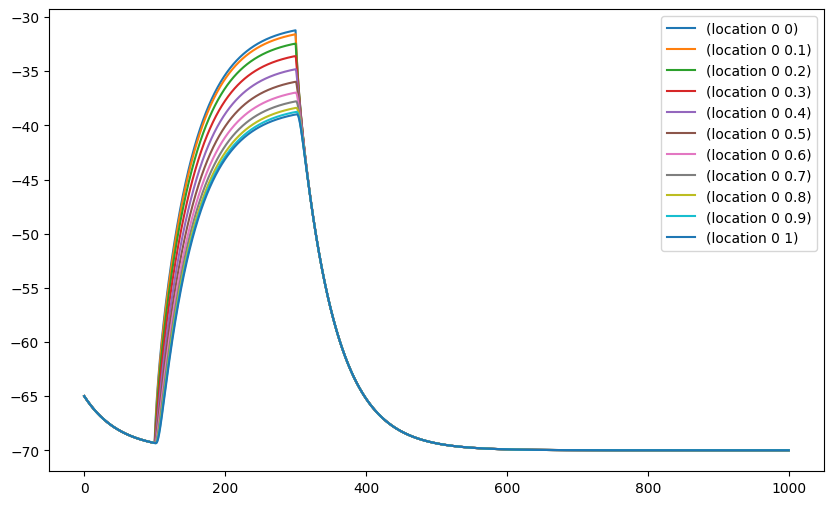

In [3]:

# Simulate the cell
print('Simulation start.')
tfinal = 1000 # ms
m.run(tfinal)
print('Simulation done.')


# Print spike times.
if len(m.spikes)>0:
    print('{} spikes:'.format(len(m.spikes)))
    for s in m.spikes:
        print('  {:7.4f}'.format(s))
else:
    print('no spikes')
    
fig=plt.figure(figsize=(10,6), dpi= 100)

for tr in m.traces:
    print(tr)
    x = np.array(tr.value)
    t = np.array(tr.time)
    plt.plot(t, x, label=tr.location)

    with open('%s.dat'%str(tr.location).replace(' ','_').replace('(','_').replace(')','_'),'w') as f:
        for ti in range(len(t)):
            f.write('%s\t%s\n'%(t[ti]/1000.0,x[ti]/1000.0))
plt.legend()
plt.show()